# Histopathologic Cancer Detection: Model Architecture

In this notebook, we'll design, implement, and train models for the Histopathologic Cancer Detection task. We'll explore different architectures, preprocessing techniques, and training strategies to develop effective models for identifying metastatic cancer in histopathology images.

## 1. Setup and Data Loading

First, let's import the necessary libraries and load the dataset.

In [59]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm.notebook import tqdm
import cv2
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16, MobileNetV2

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  0
TensorFlow version: 2.16.2


In [60]:
# Set paths to the dataset
BASE_DIR = '../data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
TRAIN_LABELS_PATH = os.path.join(BASE_DIR, 'train_labels.csv')

# Load the training labels
try:
    train_labels = pd.read_csv(TRAIN_LABELS_PATH)
    print(f"Successfully loaded training labels with shape: {train_labels.shape}")
    print("\nSample of training labels:")
    display(train_labels.head())
    
    # Check class distribution
    class_distribution = train_labels['label'].value_counts().sort_index()
    print("\nClass distribution:")
    for label, count in class_distribution.items():
        print(f"Class {label} ({'Normal' if label == 0 else 'Metastatic Cancer'}): {count} ({count/len(train_labels)*100:.2f}%)")
except Exception as e:
    print(f"Error loading training labels: {e}")
    print("Please ensure the dataset is downloaded and the paths are correctly set.")

Successfully loaded training labels with shape: (220025, 2)

Sample of training labels:


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0



Class distribution:
Class 0 (Normal): 130908 (59.50%)
Class 1 (Metastatic Cancer): 89117 (40.50%)


## 2. Data Preprocessing and Augmentation

Before we design our models, let's establish our data preprocessing and augmentation pipeline. Proper preprocessing is crucial for achieving good performance in deep learning models, especially for medical imaging tasks.

### 2.1 Image Loading and Normalization

First, we need to load the images and normalize their pixel values. Normalization helps the model converge faster and achieve better performance by ensuring that all input features are on a similar scale.

In [61]:
def load_and_preprocess_image(image_id, directory, target_size=(96, 96), normalize=True):
    """Load and preprocess an image from the specified directory"""
    try:
        img_path = os.path.join(directory, f"{image_id}.tif")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Resize if needed
        if img.shape[:2] != target_size:
            img = cv2.resize(img, target_size)
        
        # Normalize pixel values to [0, 1]
        if normalize:
            img = img.astype(np.float32) / 255.0
        
        return img
    except Exception as e:
        print(f"Error loading image {image_id}: {e}")
        return None

### 2.2 Train/Validation/Test Split

We'll split our data into training, validation, and test sets. The training set is used to train the model, the validation set is used to tune hyperparameters and monitor performance during training, and the test set is used for final evaluation.

In [62]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(
    train_labels, 
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=train_labels['label']  # Ensure class balance in both sets
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Check class distribution in the splits
print("\nClass distribution in training set:")
train_class_dist = train_df['label'].value_counts(normalize=True) * 100
for label, percentage in train_class_dist.items():
    print(f"Class {label}: {percentage:.2f}%")

print("\nClass distribution in validation set:")
val_class_dist = val_df['label'].value_counts(normalize=True) * 100
for label, percentage in val_class_dist.items():
    print(f"Class {label}: {percentage:.2f}%")

Training set size: 176020
Validation set size: 44005

Class distribution in training set:
Class 0: 59.50%
Class 1: 40.50%

Class distribution in validation set:
Class 0: 59.50%
Class 1: 40.50%


### 2.3 Data Augmentation

Data augmentation is a technique to artificially expand the training dataset by creating modified versions of the existing images. This helps prevent overfitting and improves the model's ability to generalize to new data.

For histopathology images, appropriate augmentation techniques include:

1. **Rotation**: Cells and tissue structures can appear in any orientation
2. **Flipping**: Horizontal and vertical flips don't change the medical interpretation
3. **Slight zooming**: Simulates variations in magnification
4. **Brightness/contrast adjustments**: Accounts for staining variations
5. **Slight shifts**: Helps the model focus on the relevant features regardless of their exact position

We'll use Keras' ImageDataGenerator to apply these augmentations during training.

In [63]:
# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=90,  # Random rotations up to 90 degrees
    width_shift_range=0.1,  # Random horizontal shifts
    height_shift_range=0.1,  # Random vertical shifts
    shear_range=0.1,  # Shear transformations
    zoom_range=0.1,  # Random zooming
    horizontal_flip=True,  # Random horizontal flips
    vertical_flip=True,  # Random vertical flips
    fill_mode='nearest',  # Strategy for filling in newly created pixels
    brightness_range=[0.9, 1.1]  # Random brightness adjustments
)

# For validation, we only need to normalize the pixel values
val_datagen = ImageDataGenerator(
    rescale=1./255
)

### 2.4 Visualize Augmented Images

Let's visualize some examples of augmented images to ensure our augmentation pipeline is working as expected.

In [64]:
def visualize_augmentations(image_id, directory, datagen, num_augmentations=5):
    """Visualize augmentations applied to a single image"""
    # Load the original image
    img = load_and_preprocess_image(image_id, directory, normalize=False)
    if img is None:
        return
    
    # Reshape for the data generator (batch_size=1)
    img = np.expand_dims(img, axis=0)
    
    # Create an iterator for the augmented images
    aug_iter = datagen.flow(img, batch_size=1)
    
    # Plot the original and augmented images
    plt.figure(figsize=(15, 4))
    
    # Original image
    plt.subplot(1, num_augmentations + 1, 1)
    plt.imshow(img[0].astype(np.uint8))
    plt.title('Original')
    plt.axis('off')
    
    # Augmented images
    for i in range(num_augmentations):
        aug_img = next(aug_iter)[0]
        plt.subplot(1, num_augmentations + 1, i + 2)
        plt.imshow((aug_img * 255).astype(np.uint8))
        plt.title(f'Augmentation {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Augmentations for Normal Tissue Sample (ID: ccfa56275765b892dc874b2a75d73c2b34ad7247)


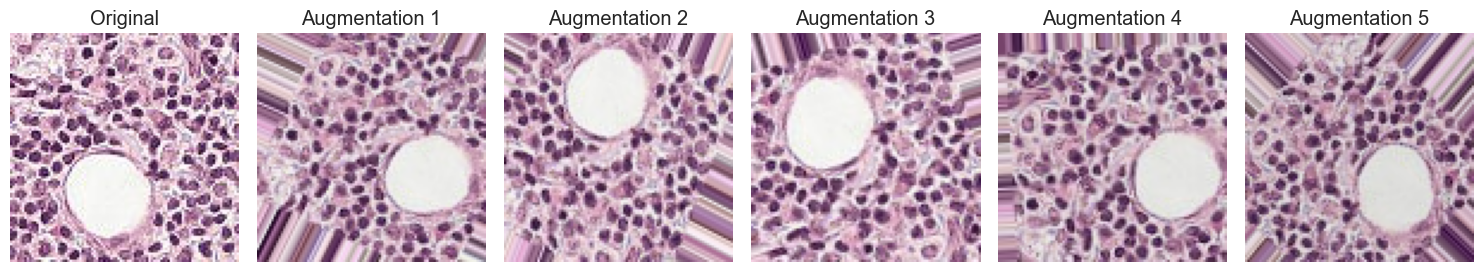

Augmentations for Cancer Tissue Sample (ID: 93afd09698d149358cb778711bda663309ca3d81)


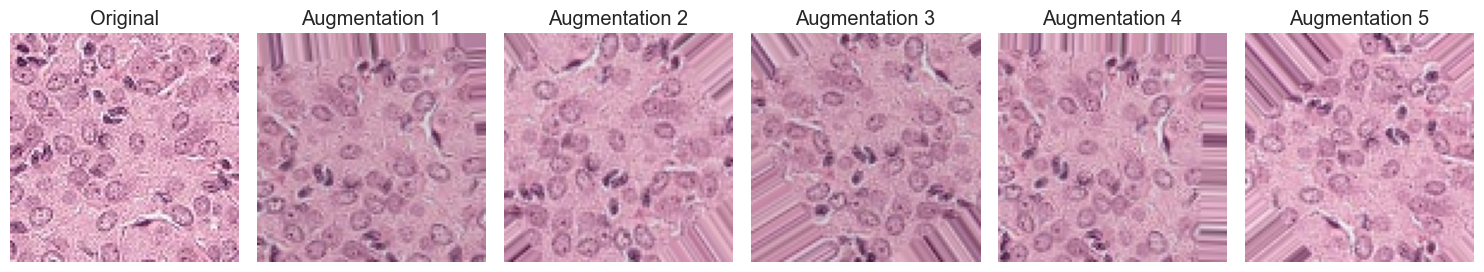

In [65]:
# Visualize augmentations for a normal tissue sample
normal_sample = train_df[train_df['label'] == 0].sample(1)['id'].values[0]
print(f"Augmentations for Normal Tissue Sample (ID: {normal_sample})")
visualize_augmentations(normal_sample, TRAIN_DIR, train_datagen)

# Visualize augmentations for a cancer tissue sample
cancer_sample = train_df[train_df['label'] == 1].sample(1)['id'].values[0]
print(f"Augmentations for Cancer Tissue Sample (ID: {cancer_sample})")
visualize_augmentations(cancer_sample, TRAIN_DIR, train_datagen)

### 2.5 Data Generators

Now, let's create data generators for training and validation. These generators will load and preprocess images in batches, which is more memory-efficient than loading the entire dataset at once.

In [66]:
def create_data_generators(train_df, val_df, train_dir, batch_size=32):
    train_df = train_df.copy()
    val_df = val_df.copy()
    train_df['label'] = train_df['label'].astype(str)
    val_df['label'] = val_df['label'].astype(str)

        # Append .tif extension to image IDs
    train_df['id'] = train_df['id'] + ".tif"
    val_df['id'] = val_df['id'] + ".tif"
    """Create data generators for training and validation"""
    # Training generator with augmentation
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir,
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        validate_filenames=False,  # Skip validation for speed
        shuffle=True,
        seed=42
    )
    
    # Validation generator without augmentation
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=train_dir,
        x_col='id',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        validate_filenames=False,  # Skip validation for speed
        shuffle=False
    )
    
    return train_generator, val_generator

In [67]:
# Create data generators
batch_size = 32
train_generator, val_generator = create_data_generators(train_df, val_df, TRAIN_DIR, batch_size)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


## 3. Model Architectures

Now, let's design and implement different model architectures for the histopathologic cancer detection task. We'll explore three main approaches:

1. Custom CNN from scratch
2. Transfer learning with pre-trained models
3. Vision transformers

For each approach, we'll discuss its strengths, weaknesses, and suitability for histopathology image analysis.

### 3.1 Custom CNN from Scratch

Building a custom CNN from scratch gives us full control over the architecture and allows us to tailor it specifically to our task. This approach is useful when we have domain-specific knowledge about the problem or when pre-trained models might not be suitable.

**Strengths:**
- Full control over architecture design
- Can be tailored specifically for histopathology images
- Potentially smaller and faster than pre-trained models
- Better interpretability due to simpler architecture

**Weaknesses:**
- Requires more data to train effectively
- May not capture complex patterns as well as deeper pre-trained models
- Requires more hyperparameter tuning
- May take longer to converge

**Why it might work for histopathology:**
- Histopathology images have specific characteristics (cell structures, tissue patterns) that a custom CNN can be designed to detect
- The task is relatively focused (binary classification of a specific type of cancer)
- The image size is manageable (96x96 pixels)

In [68]:
def create_custom_cnn(input_shape=(96, 96, 3)):
    """Create a custom CNN model for histopathology image classification"""
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

# Create and compile the custom CNN model
custom_cnn = create_custom_cnn()
custom_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Display model summary
custom_cnn.summary()

/Users/luke/src/github.com/lukelittle/csca5642-histopathologic-cancer-detection/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 512)            │         2,04

 Total params: 5,895,841 (22.49 MB)

 Trainable params: 5,893,857 (22.48 MB)

 Non-trainable params: 1,984 (7.75 KB)

**Architecture Explanation:**

Our custom CNN consists of four convolutional blocks, each followed by max pooling, batch normalization, and dropout:

1. **Convolutional Blocks**: Each block contains two convolutional layers with increasing filter sizes (32 → 64 → 128 → 256). This allows the network to learn increasingly complex features.
   
2. **Max Pooling**: Reduces spatial dimensions, making the network more computationally efficient and helping it focus on the most important features.
   
3. **Batch Normalization**: Normalizes the activations of the previous layer, which helps with faster convergence and reduces the risk of overfitting.
   
4. **Dropout**: Randomly sets a fraction of input units to 0 during training, which helps prevent overfitting.
   
5. **Dense Layers**: After flattening, we have a dense layer with 512 units, followed by the output layer with a sigmoid activation function for binary classification.

This architecture is designed to capture both low-level features (like edges and textures) and high-level features (like cell structures and tissue patterns) in histopathology images.

### 3.2 Transfer Learning with Pre-trained Models

Transfer learning involves using a pre-trained model (trained on a large dataset like ImageNet) as a starting point and fine-tuning it for our specific task. This approach leverages the knowledge learned from a large and diverse dataset, which can be beneficial even for specialized tasks like histopathology image analysis.

**Strengths:**
- Leverages knowledge from pre-training on large datasets
- Requires less data to achieve good performance
- Often converges faster during training
- Can capture complex patterns and features

**Weaknesses:**
- Pre-trained models are typically trained on natural images, which differ from histopathology images
- Larger models with more parameters, which can lead to overfitting
- Higher computational requirements
- Less interpretable due to complex architectures

**Why it might work for histopathology:**
- Despite differences between natural and histopathology images, low-level features (edges, textures) are still relevant
- Pre-trained models have learned robust feature representations that can generalize to new domains
- Fine-tuning allows the model to adapt to the specific characteristics of histopathology images

We'll implement transfer learning with three popular architectures: ResNet50, EfficientNetB0, and MobileNetV2.

In [69]:
def create_transfer_learning_model(base_model_name, input_shape=(96, 96, 3), trainable=False):
    """Create a transfer learning model using a pre-trained base model"""
    # Select the base model
    if base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'efficientnet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'mobilenet':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported base model: {base_model_name}")
    
    # Freeze the base model if not trainable
    base_model.trainable = trainable
    
    # Create the model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [70]:
# Create and compile the ResNet50 model
resnet_model = create_transfer_learning_model('resnet50', trainable=False)
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Display model summary
print("ResNet50 Transfer Learning Model:")
resnet_model.summary()

ResNet50 Transfer Learning Model:


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,537 (91.99 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [71]:
# Create and compile the EfficientNetB0 model
efficientnet_model = create_transfer_learning_model('efficientnet', trainable=False)
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Display model summary
print("EfficientNetB0 Transfer Learning Model:")
efficientnet_model.summary()

EfficientNetB0 Transfer Learning Model:


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,788 (16.70 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [72]:
# Create and compile the MobileNetV2 model
mobilenet_model = create_transfer_learning_model('mobilenet', trainable=False)
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Display model summary
print("MobileNetV2 Transfer Learning Model:")
mobilenet_model.summary()

MobileNetV2 Transfer Learning Model:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [73]:
# Create models directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)

In [74]:
# Define callbacks for model training
def get_callbacks(model_name):
    return [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=3),
        ModelCheckpoint(
            filepath=os.path.join(MODELS_DIR, f"{model_name}.keras"),
            save_best_only=True,
            monitor='val_auc',
            mode='max'
        )
    ]

In [75]:
# Train and save models
# Note: For demonstration purposes, we'll use a small number of epochs
# In a real scenario, you might want to train for more epochs
epochs = 5

In [ ]:
# Train and save the custom CNN model
print("\nTraining custom CNN model...")
custom_cnn_history = custom_cnn.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=get_callbacks('custom_cnn')
)
custom_cnn.save(os.path.join(MODELS_DIR, 'custom_cnn.keras'))
print(f"Custom CNN model saved to {os.path.join(MODELS_DIR, 'custom_cnn.keras')}")


Training custom CNN model...


/Users/luke/src/github.com/lukelittle/csca5642-histopathologic-cancer-detection/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 748/5501 ━━━━━━━━━━━━━━━━━━━━ 58:52 743ms/step - accuracy: 0.7425 - auc: 0.8008 - loss: 0.6240

In [ ]:
# Train and save the ResNet50 model
print("\nTraining ResNet50 model...")
resnet_history = resnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=get_callbacks('resnet50')
)
resnet_model.save(os.path.join(MODELS_DIR, 'resnet50.h5'))
print(f"ResNet50 model saved to {os.path.join(MODELS_DIR, 'resnet50.keras')}")

In [ ]:
# Train and save the EfficientNetB0 model
print("\nTraining EfficientNetB0 model...")
efficientnet_history = efficientnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=get_callbacks('efficientnet')
)
efficientnet_model.save(os.path.join(MODELS_DIR, 'efficientnet.h5'))
print(f"EfficientNetB0 model saved to {os.path.join(MODELS_DIR, 'efficientnet.keras')}")

In [ ]:
# Train and save the MobileNetV2 model
print("\nTraining MobileNetV2 model...")
mobilenet_history = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=get_callbacks('mobilenet')
)
mobilenet_model.save(os.path.join(MODELS_DIR, 'mobilenet.h5'))
print(f"MobileNetV2 model saved to {os.path.join(MODELS_DIR, 'mobilenet.keras')}")

print("\nAll models have been trained and saved to the '../models' directory.")

**Architecture Explanation:**

For our transfer learning models, we're using pre-trained networks (ResNet50, EfficientNetB0, and MobileNetV2) as feature extractors. Here's how our architecture works:

1. **Pre-trained Base Model**: We use the convolutional layers of the pre-trained model (without the top classification layers) to extract features from our images. Initially, we freeze these layers to preserve the learned features.

2. **Global Average Pooling**: This reduces the spatial dimensions of the feature maps, resulting in a fixed-size feature vector regardless of input size.

3. **Custom Top Layers**: We add our own fully connected layers on top of the base model:
   - A dropout layer to prevent overfitting
   - A dense layer with ReLU activation to learn task-specific features
   - Batch normalization to stabilize training
   - Another dropout layer
   - A final output layer with sigmoid activation for binary classification

This approach allows us to leverage the powerful feature extraction capabilities of pre-trained models while adapting them to our specific task of histopathologic cancer detection.